# EDA


In [3]:
# Importing all required library
import pandas as pd
import numpy as np
import seaborn as sns
from math import radians, cos, sin, asin, acos, sqrt, pi
from geopy import distance
from geopy.geocoders import Nominatim
import osmnx as ox
import networkx as nx
from statistics import  mode
import matplotlib.pyplot as plt

In [4]:
# Reading  Data from csv
df=pd.read_csv('/config/workspace/Delivery_Time_prediction/finalTrain.csv')

In [5]:
# created function which display unique values
def unique_value_count(df_data):
    """
        unique_value_count(df_data) 
        df_data: DataFrame
        Returning the dict of count of unique values in dataset for each feature in the dictionary format"""
    unique_values=dict()
    for col in df_data.columns:
        unique_values[col]=len(df_data[col].unique())
    return unique_values


In [6]:
# getting shape of dataframe
df.shape

(45584, 20)

In [7]:
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min)
0,0xcdcd,DEHRES17DEL01,36.0,4.2,30.327968,78.046106,30.397968,78.116106,12-02-2022,21:55,22:10,Fog,Jam,2,Snack,motorcycle,3.0,No,Metropolitian,46
1,0xd987,KOCRES16DEL01,21.0,4.7,10.003064,76.307589,10.043064,76.347589,13-02-2022,14:55,15:05,Stormy,High,1,Meal,motorcycle,1.0,No,Metropolitian,23
2,0x2784,PUNERES13DEL03,23.0,4.7,18.562450,73.916619,18.652450,74.006619,04-03-2022,17:30,17:40,Sandstorms,Medium,1,Drinks,scooter,1.0,No,Metropolitian,21
3,0xc8b6,LUDHRES15DEL02,34.0,4.3,30.899584,75.809346,30.919584,75.829346,13-02-2022,09:20,09:30,Sandstorms,Low,0,Buffet,motorcycle,0.0,No,Metropolitian,20
4,0xdb64,KNPRES14DEL02,24.0,4.7,26.463504,80.372929,26.593504,80.502929,14-02-2022,19:50,20:05,Fog,Jam,1,Snack,scooter,1.0,No,Metropolitian,41


### Data pre-processing 

In [8]:
# Displaying all features of raw dataset
df.columns

Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked', 'Weather_conditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken (min)'],
      dtype='object')

In [9]:
# Checking null values

for col in df.columns:
    if df[col].isnull().sum():
        print(f"{col} : {df[col].isnull().sum()}")



Delivery_person_Age : 1854
Delivery_person_Ratings : 1908
Time_Orderd : 1731
Weather_conditions : 616
Road_traffic_density : 601
multiple_deliveries : 993
Festival : 228
City : 1200


In [10]:
df.dtypes

ID                              object
Delivery_person_ID              object
Delivery_person_Age            float64
Delivery_person_Ratings        float64
Restaurant_latitude            float64
Restaurant_longitude           float64
Delivery_location_latitude     float64
Delivery_location_longitude    float64
Order_Date                      object
Time_Orderd                     object
Time_Order_picked               object
Weather_conditions              object
Road_traffic_density            object
Vehicle_condition                int64
Type_of_order                   object
Type_of_vehicle                 object
multiple_deliveries            float64
Festival                        object
City                            object
Time_taken (min)                 int64
dtype: object

dropping ID and Delivery_person_ID Column as it is irrelevant for our analysis

    * Assuming that each delivery person is working with same pace

In [11]:
df.drop(['ID','Delivery_person_ID'],inplace=True,axis=1)

Creating time taken for pickup the order from restaurant 

In [12]:

df['Time_Orderd']=df['Time_Orderd'].apply( lambda x:  (float(x.split(":")[0]) * 60 + (float(x.split(":")[1]))) if ((isinstance(x,str))and(":" in x))   else np.nan  )
df['Time_Order_picked']=df['Time_Order_picked'].apply( lambda x:  (float(x.split(":")[0]) * 60 + (float(x.split(":")[1]))) if ((isinstance(x,str))and(":" in x))   else np.nan  )

df['Time_pickup_(Min)']=df['Time_Order_picked']-df['Time_Orderd']       # Converting both features into single feature
df['Time_pickup_(Min)']=df['Time_pickup_(Min)'].fillna(round(np.mean(df['Time_pickup_(Min)']),2))                     # handling missing value in that feature
df.drop(['Time_Orderd','Time_Order_picked'],inplace=True,axis=1)

Splitting Date in Day Month Year in seperate columns

In [13]:
df['Order_Date'].apply(lambda x: x.split("-")[2]).unique()

array(['2022'], dtype=object)

There is only single year so we can skip making year column

In [14]:

df['Order_Day']=df['Order_Date'].apply(lambda x: int(x.split("-")[0]))
df['Order_Month']=df['Order_Date'].apply(lambda x: int(x.split("-")[1]))
df.drop('Order_Date',inplace=True,axis=1)


Getting delivery distance 

In [15]:

def calculate_spherical_distance(lat1, lon1, lat2, lon2, r=6371):
    # Convert degrees to radians
    coordinates = abs(lat1), abs(lon1), abs(lat2), abs(lon2)
    # radians(c) is same as c*pi/180
    phi1, lambda1, phi2, lambda2 = [
        radians(c) for c in coordinates
    ]  
    
    # Apply the haversine formula
    a = (np.square(sin((phi2-phi1)/2)) + cos(phi1) * cos(phi2) * 
         np.square(sin((lambda2-lambda1)/2)))
    d = 2*r*asin(np.sqrt(a))
    return d

In [16]:
# Appending distance to list 
Dist_list=list()
for lat1,lon1,lat2,lon2 in df[['Restaurant_latitude'	,'Restaurant_longitude'	,'Delivery_location_latitude'	,'Delivery_location_longitude']].values:
    Dist_list.append(round(calculate_spherical_distance(lat1,lon1,lat2,lon2),2))
df['Distance']=np.array(Dist_list)
df.drop(['Restaurant_latitude'	,'Restaurant_longitude'	,'Delivery_location_latitude'	,'Delivery_location_longitude'],inplace=True,axis=1)

In [17]:
df

,Delivery_person_Age,Delivery_person_Ratings,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min),Time_pickup_(Min),Order_Day,Order_Month,Distance
0,36.0,4.2,Fog,Jam,2,Snack,motorcycle,3.0,No,Metropolitian,46,15.0,12,2,10.28
1,21.0,4.7,Stormy,High,1,Meal,motorcycle,1.0,No,Metropolitian,23,10.0,13,2,6.24
2,23.0,4.7,Sandstorms,Medium,1,Drinks,scooter,1.0,No,Metropolitian,21,10.0,4,3,13.79
3,34.0,4.3,Sandstorms,Low,0,Buffet,motorcycle,0.0,No,Metropolitian,20,10.0,13,2,2.93
4,24.0,4.7,Fog,Jam,1,Snack,scooter,1.0,No,Metropolitian,41,15.0,14,2,19.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45579,30.0,4.8,Windy,High,1,Meal,motorcycle,0.0,No,Metropolitian,32,10.0,24,3,1.49
45580,21.0,4.6,Windy,Jam,0,Buffet,motorcycle,1.0,No,Metropolitian,36,15.0,16,2,11.01
45581,30.0,4.9,Cloudy,Low,1,Drinks,scooter,0.0,No,Metropolitian,16,15.0,11,3,4.66
45582,20.0,4.7,Cloudy,High,0,Snack,motorcycle,1.0,No,Metropolitian,26,5.0,7,3,6.23


In [18]:
# Getting all unique value count
unique_value_count(df)

{'Delivery_person_Age': 23,
 'Delivery_person_Ratings': 29,
 'Weather_conditions': 7,
 'Road_traffic_density': 5,
 'Vehicle_condition': 4,
 'Type_of_order': 4,
 'Type_of_vehicle': 4,
 'multiple_deliveries': 5,
 'Festival': 3,
 'City': 4,
 'Time_taken (min)': 45,
 'Time_pickup_(Min)': 4,
 'Order_Day': 30,
 'Order_Month': 3,
 'Distance': 267}

Handlling missing values of Deliverry person age and his rating with mean and mode resptively.

In [19]:

df['Delivery_person_Age']=df['Delivery_person_Age'].fillna(np.mean(df['Delivery_person_Age']))

df['Delivery_person_Ratings']=df['Delivery_person_Ratings'].fillna(np.mean(df['Delivery_person_Ratings']))

Handlling misssing values of multile delivery with mode value 

In [20]:
df.multiple_deliveries.fillna(mode(df.multiple_deliveries),inplace=True)

Handlling the Festival feature for yes no values and missing values

In [21]:
df['Festival'].value_counts()
# .plot(kind='bar',figsize=(3,3))

Festival
No     44460
Yes      896
Name: count, dtype: int64

from obersation that more than 90% of the dataset is of no festival, hence we can give missing value as No  

In [22]:
df['Festival']=df['Festival'].fillna(mode(df['Festival']))

Handlling missing values of weather_condition feature 

count     44968
unique        6
top         Fog
freq       7653
Name: Weather_conditions, dtype: object

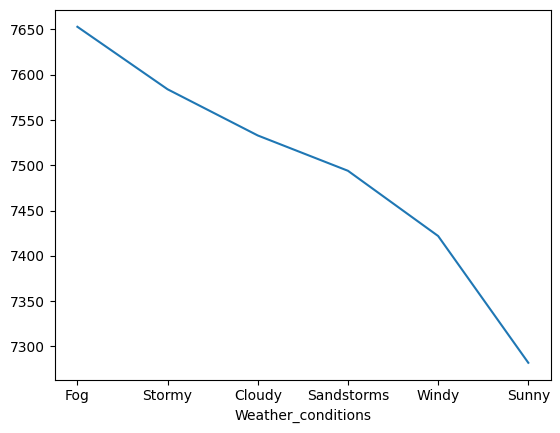

In [23]:
df['Weather_conditions'].value_counts().plot()

df['Weather_conditions'].describe()

From observation we can conclude that all categories are almost evenly distributed where sunny weather is least, to avoid bais we are using mode to replace missing values

In [24]:
df['Weather_conditions']=df['Weather_conditions'].fillna(mode(df['Weather_conditions']))

Handlling road traffic density missing values

<Axes: xlabel='Road_traffic_density'>

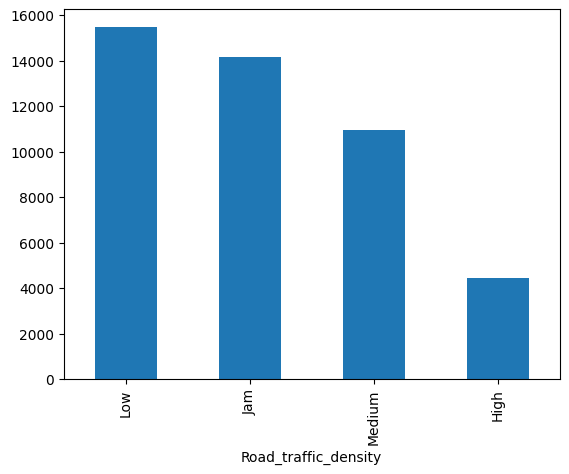

In [25]:
df['Road_traffic_density'].value_counts().plot(kind='bar')

Here we can observe data is not evenly spread for high traffic density data is less, we are applying max frequent variable to replace the missing values

In [26]:
df['Road_traffic_density']=df['Road_traffic_density'].fillna(mode(df['Road_traffic_density']))

Handlling City feature missing values

count             44384
unique                3
top       Metropolitian
freq              34087
Name: City, dtype: object

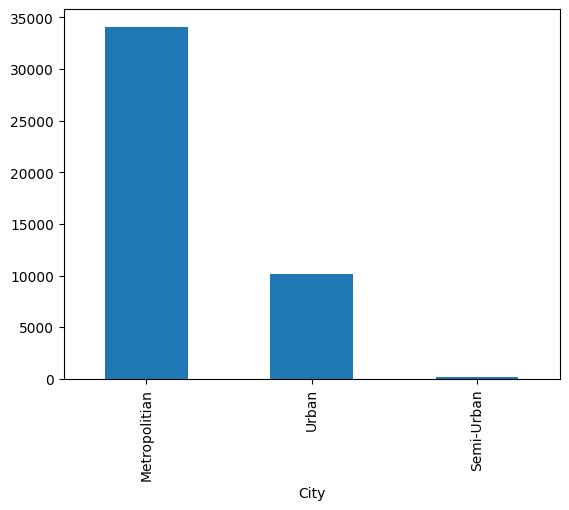

In [27]:

df.City.value_counts().plot(kind='bar')
df.City.describe()

Replacing missing values with mode 

In [28]:
df['City']=df['City'].fillna(mode(df['City']))

In [30]:
## segregate numerical and categorical columns

numerical_columns=df.columns[df.dtypes!='object']
categorical_columns=df.columns[df.dtypes=='object']
print("Numerical columns:",numerical_columns)
print('Categorical Columns:',categorical_columns)

Numerical columns: Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Vehicle_condition',
       'multiple_deliveries', 'Time_taken (min)', 'Time_pickup_(Min)',
       'Order_Day', 'Order_Month', 'Distance'],
      dtype='object')
Categorical Columns: Index(['Weather_conditions', 'Road_traffic_density', 'Type_of_order',
       'Type_of_vehicle', 'Festival', 'City'],
      dtype='object')


In [31]:
def describe_categorical_column_wtr_target(categorical_columns,target_feature):

    for col in categorical_columns:
        print(df.groupby(col)[target_feature].describe())
        print('==='*30)

In [32]:
# Impact of each feature w.r.t. target

describe_categorical_column_wtr_target(categorical_columns,'Time_taken (min)')

                     count       mean        std   min   25%   50%   75%   max
Weather_conditions                                                            
Cloudy              7533.0  28.917164  10.086234  10.0  20.0  28.0  37.0  54.0
Fog                 8269.0  28.738179  10.100667  10.0  20.0  28.0  37.0  54.0
Sandstorms          7494.0  25.875500   8.619009  10.0  20.0  26.0  31.0  54.0
Stormy              7584.0  25.868803   8.473481  10.0  20.0  26.0  31.0  54.0
Sunny               7282.0  21.856770   8.328310  10.0  16.0  20.0  26.0  54.0
Windy               7422.0  26.118836   8.615702  10.0  20.0  26.0  31.0  54.0
                        count       mean       std   min   25%   50%   75%   
Road_traffic_density                                                         
High                   4423.0  27.240109  8.397667  10.0  22.0  27.0  32.0  \
Jam                   14139.0  31.176038  9.941898  10.0  24.0  31.0  39.0   
Low                   16077.0  21.463893  6.988564  10.0

In [ ]:
# Checking the dataset discrepancies 
df[numerical_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
Delivery_person_Age,45584.0,29.566911,5.695578,15.00,25.00,29.566911,34.00,50.00
Delivery_person_Ratings,45584.0,4.633774,0.327663,1.00,4.60,4.700000,4.80,6.00
Vehicle_condition,45584.0,1.023385,0.839055,0.00,0.00,1.000000,2.00,3.00
multiple_deliveries,45584.0,0.750197,0.567465,0.00,0.00,1.000000,1.00,3.00
Time_taken (min),45584.0,26.293963,9.384298,10.00,19.00,26.000000,32.00,54.00
Time_pickup_(Min),45584.0,9.983759,3.623117,5.00,5.00,10.000000,15.00,15.00
Order_Day,45584.0,13.810920,8.708532,1.00,6.00,13.000000,20.00,31.00
Order_Month,45584.0,2.980673,0.545939,2.00,3.00,3.000000,3.00,4.00
Distance,45584.0,9.735135,5.608022,1.47,4.66,9.220000,13.68,20.97


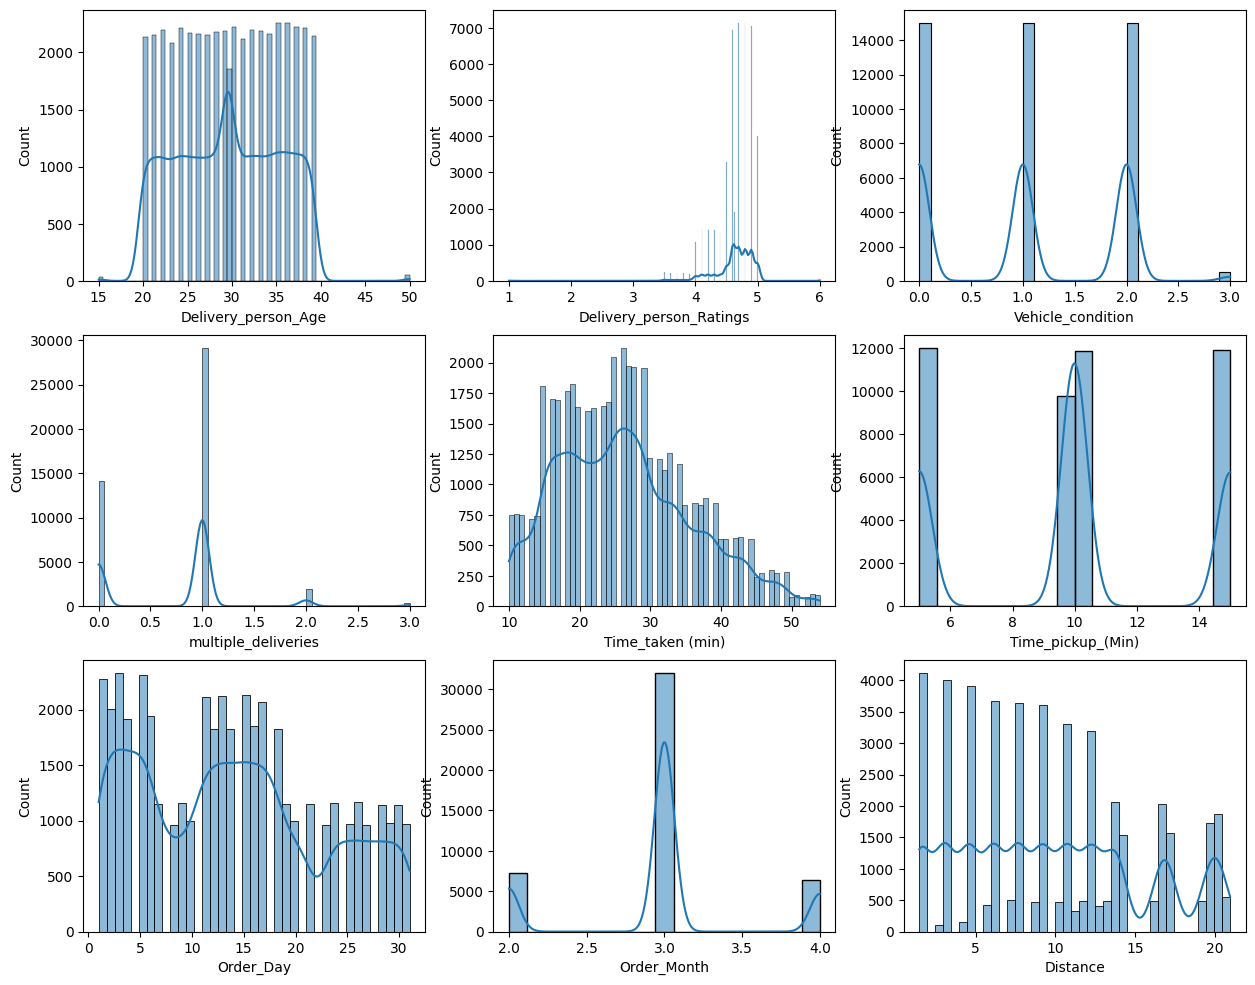

In [ ]:
plt.figure(figsize=(15,50), facecolor='white')
plotnumber =1

for column in numerical_columns:
    ax = plt.subplot(12,3,plotnumber)
    sns.histplot(df[column],kde=True)
    plt.xlabel(column,fontsize=10)
    plotnumber+=1
plt.show()

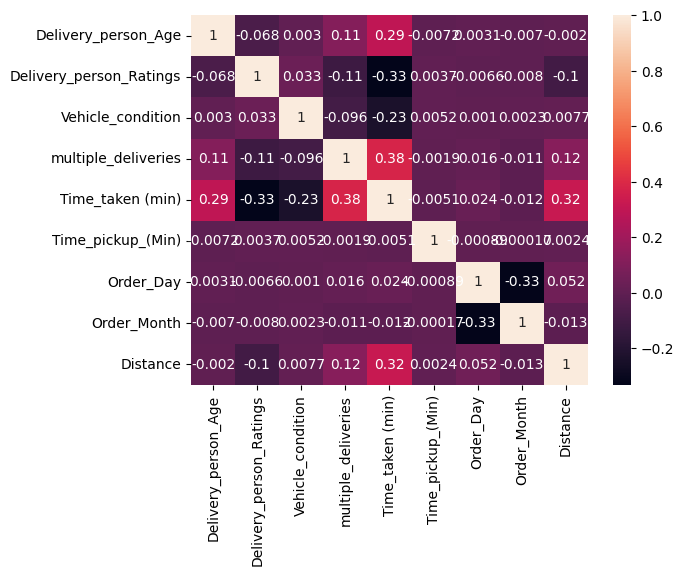

In [38]:
sns.heatmap(df[numerical_columns].corr(),annot=True)


Converting Data set to CSV format

In [ ]:
# df.to_csv("data/Final_Raw.csv",index=False)